# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 1-1

#### (a) Implement a multi-layer neural networks to simulate a function $y = f(x)$ to fit the data given in `HW1-1.csv`. For every input $x$, give an output $y$. The mean-square error between the output and ground truth has to be less than 0.1

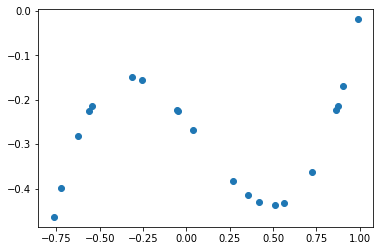

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# Prepare dataset
X_raw = []
Y_raw = []
with open('HW1-1.csv', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        X_raw.append(float(row['x']))
        Y_raw.append(float(row['y']))
        
plt.scatter(X_raw, Y_raw)

X = np.array(X_raw).reshape(-1, 1)
Y = np.array(Y_raw).reshape(-1, 1)
dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(X, tf.float32),
    tf.cast(Y, tf.float32)
)).shuffle(100).batch(20)

### It's polynomial!

In [2]:
# Build model
class NN(tf.keras.Model):
    def __init__(self):
        super(NN, self).__init__(name='NN')
        self.fc = [
            tf.keras.layers.Dense(100, activation="tanh", name='layer1'),
            tf.keras.layers.Dense(100, activation="tanh", name='layer2'),
            tf.keras.layers.Dense(1, name='output')
        ]
    def call(self, x):
        for layer in self.fc:
            x = layer(x)
        return x
    def summary(self): # a hack in order to properly output summary
        x = tf.keras.Input(shape=(1), name='input')
        tf.keras.Model(inputs=x, outputs=self.call(x), name='NN').summary()
        
model = NN()
model.summary()

def MSE(y_pred, y_true):
    return tf.reduce_mean((y_pred - y_true)**2)
optimizer = tf.keras.optimizers.Adam()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               200       
_________________________________________________________________
layer2 (Dense)               (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [3]:
def train(model, X, Y):
    with tf.GradientTape() as tape:
        out = model(X)
        loss = MSE(out, Y)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [4]:
for epoch in range(300):
    for X, Y in dataset:
        loss = train(model, X, Y)
    if epoch%30 == 0:
        print("Loss at epoch {:03d}: {:.3f}".format(epoch, loss))

Loss at epoch 000: 0.097
Loss at epoch 030: 0.014
Loss at epoch 060: 0.014
Loss at epoch 090: 0.014
Loss at epoch 120: 0.013
Loss at epoch 150: 0.011
Loss at epoch 180: 0.006
Loss at epoch 210: 0.001
Loss at epoch 240: 0.001
Loss at epoch 270: 0.001


### Inference

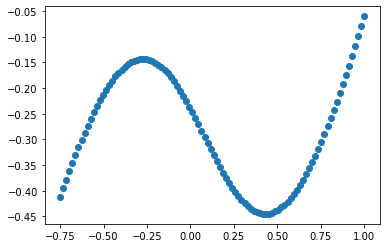

In [5]:
def inference(model):
    X_test = np.linspace(-.75, 1, 100).reshape(-1, 1).astype(np.float32)
    out = model(X_test).numpy()  
    plt.scatter(X_test.reshape(-1), out.reshape(-1))
inference(model)

#### (b) Implement a polynomial function $y = w_mx^m + \cdots + w_1x^1 + w_0$ to fit the data given in `HW1-1.csv`. For every input $x$, give an output $y$.

In [6]:
# Build model
class Poly(tf.keras.Model):
    def __init__(self):
        super(Poly, self).__init__(name='Poly')
        self.coef = {
            'w3': tf.Variable(1., name='w3'),
            'w2': tf.Variable(-.2, name='w2'),
            'w1': tf.Variable(-.6, name='w1'),
            'w0': tf.Variable(-.3, name='w0')
        }
    def call(self, x):
        out = self.coef['w0']
        for i in range(1, 4):
            out = out + x**i * self.coef['w'+str(i)]
        return out
        
model_poly = Poly()

In [7]:
# train
X = np.array(X_raw).reshape(-1, 1)
Y = np.array(Y_raw).reshape(-1, 1)

for epoch in range(300):
    loss = train(model_poly, X, Y)
    if epoch%30 == 0:
        print("Loss at epoch {:03d}: {:.3f}".format(epoch, loss))

Loss at epoch 000: 0.005
Loss at epoch 030: 0.000
Loss at epoch 060: 0.000
Loss at epoch 090: 0.000
Loss at epoch 120: 0.000
Loss at epoch 150: 0.000
Loss at epoch 180: 0.000
Loss at epoch 210: 0.000
Loss at epoch 240: 0.000
Loss at epoch 270: 0.000


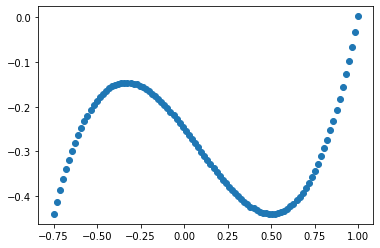

In [8]:
inference(model_poly)

(i) Print the coefficients $w_mx^m, \cdots, w_0$

In [9]:
print(
    f"w3 = {model_poly.coef['w3'].numpy(): .2f}, "
    f"w2 = {model_poly.coef['w2'].numpy(): .2f}, "
    f"w1 = {model_poly.coef['w1'].numpy(): .2f}, "
    f"w0 = {model_poly.coef['w0'].numpy(): .2f}"
)

w3 =  1.01, w2 = -0.26, w1 = -0.51, w0 = -0.25


(ii) Calculate the gradients: $f'(0.7), f'(0.2), f'(-0.5)$.

In [10]:
def calGrad(f, x):
    x = tf.Variable(x)
    with tf.GradientTape() as tape:
        y = f(x)
    return tape.gradient(y, x)

print(
    f"f'(0.7) = {calGrad(model_poly, 0.7).numpy(): .2f}, "
    f"f'(0.2) = {calGrad(model_poly, 0.2).numpy(): .2f}, "
    f"f'(-0.5) = {calGrad(model_poly, -0.5).numpy(): .2f}"
)

f'(0.7) =  0.63, f'(0.2) = -0.49, f'(-0.5) =  0.51
